In [1]:
# stdlib imports
from datetime import datetime
import os
import re
import warnings
import sys
import scipy.constants as sp
import pandas as pd

# third party
from obspy.core.trace import Trace
from obspy.core.stream import Stream
from obspy.core.trace import Stats
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

import processing
import arias_intensity

In [2]:
data_dir = '/Users/tnye/PROJECTS/Duration/data/ci3144585/ground_motion'
file_names = ['1994.c.017m30su.n0a',
              '1994.c.017m30su.n0b',
              '1994.c.017m30su.n0c']
files = [os.path.join(data_dir, f) for f in file_names]
stream = Stream()

for i in range(len(files)):
    cmp = processing.read_data(files[i], units='acc')[0]
    stream.append(cmp)
    
for i, trace in enumerate(stream):
    trace_stats = trace.stats
    channel = trace.stats['channel']
    dt = trace_stats.delta

acc = trace.data

In [3]:
from obspy.core.trace import Trace
from obspy.core.stream import Stream
from obspy.core.trace import Stats
from amptools.io.knet.core import read_knet
from amptools.stream import group_channels
from obspy.core.stream import Stream
from obspy import UTCDateTime

import glob
import os

import sys
from libcomcat.search import get_event_by_id
from obspy.geodetics import gps2dist_azimuth, kilometers2degrees
from obspy.taup import TauPyModel

stream = Stream()
trace = Trace()

In [6]:
# read knet
from obspy import read 

os.chdir("/Users/tnye/PROJECTS/Duration/data/usp000a1b0/ground_motion/knt")
types = ('*.EW', '*.NS', '*.UD')
files_grabbed = []
for files in types:
    files_grabbed.extend(glob.glob(files))

data = []
for i in range(len(files_grabbed)):
    data.append(read(files_grabbed[i]))

stations = group_channels(data)

In [7]:
station_stats = []
for i in range(len(stations)):
    station = stations[i]
    trace = station[0]
    name = trace.stats['station']
    lat = trace.stats['knet']['stla']
    lon = trace.stats['knet']['stlo']
    elev = trace.stats['knet']['evlo']
    station_stats.append([name, lat, lon, elev])

In [8]:
# earthquake data
event_id = 'usp000a1b0'
detail = get_event_by_id(event_id)
date = UTCDateTime(detail.time)
mag = detail.magnitude
lat = detail.latitude
lon = detail.longitude
source_coords = [lat, lon]
depth = detail.depth
print(date)

2000-10-06T04:30:19.150000Z


In [9]:
# append station stats 
model = TauPyModel(model="iasp91")
station_dist = []           # unsorted
p_arrivals = []             # unsorted
for sta in stations:
    distances = []
    arrivals = []
    for i in range(len(sta)):
        trace = sta[i]
        dkm = gps2dist_azimuth(trace.stats['knet']['stla'],
                                trace.stats['knet']['stlo'],
                                source_coords[0], source_coords[1])
        dkm = dkm[0] / 1000.0
        dd = kilometers2degrees(dkm)
        p = model.get_travel_times(depth, dd, phase_list=['p', 'P'])
        
        trace.stats.rdist = dkm    
        trace.stats.P_arriv = p[0].time
        distances.append(dkm)
        arrivals.append(p)
    station_dist.append(distances[0])
    p_arrivals.append(arrivals[0])

In [10]:
import matplotlib.pyplot as plt
from obspy import read
from matplotlib.dates import date2num
from matplotlib.pyplot import close
import warnings
warnings.filterwarnings('ignore')

In [11]:
stz = Stream()
for sta in stations:
    newtrace = sta.select(channel='UD')
    #newtrace[0].stats.starttime = newtrace[0].stats.starttime - 9.*3600
    stz += newtrace
    
sorted_stz = stz.sort(keys=['rdist'])

<function matplotlib.pyplot.show(*args, **kw)>

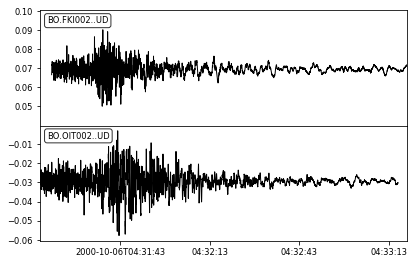

In [45]:
new_sorted = sorted_stz[199:201]

fig = plt.figure()
new_sorted.plot(fig=fig, show=False)
for i in range(len(new_sorted)):
    p_onset = date + new_sorted[i].stats['P_arriv']
    
    ax = fig.axes[i]
    ax.axvline(date2num(p_onset.datetime), lw=2)
plt.show

In [17]:
close('all')

In [14]:
#print(Stream.__str__(sorted_stz, extended=True))

In [51]:
for sta in sorted_stz:
    sta = trace
    p_onset = date + trace.stats['P_arriv']
    if (trace.stats['starttime'] - p_onset) > 2:
        sorted_stz.remove(trace)
print(len(sorted_stz))

303


In [50]:
i = 199
print(sorted_stz[i].stats['station'])
p_onset = date + sorted_stz[i].stats['P_arriv']
print(sorted_stz[i].stats['starttime'] - p_onset)

FKI002
21.337774


In [56]:
print(date2num(p_onset.datetime))

730399.1880840131
